In [1]:
# %load_ext autoreload
# %autoreload 2
# import os
# os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-17'
import straindesign as sd
import straindesign.names as names

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cobra
import logging
logging.basicConfig(level=logging.INFO)
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [3]:
from syn_elong import model
from syn_elong.media import m9_media

Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Set parameter GURO_PAR_SPECIAL


INFO:gurobipy.gurobipy:Set parameter GURO_PAR_SPECIAL


Set parameter TokenServer to value "leghorn"


INFO:gurobipy.gurobipy:Set parameter TokenServer to value "leghorn"


In [4]:
model.medium = m9_media
consistent_model = cobra.flux_analysis.fastcc(model)
consistent_model.mediu = m9_media

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpykpmgaij.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpykpmgaij.lp


Reading time = 0.04 seconds


INFO:gurobipy.gurobipy:Reading time = 0.04 seconds


: 893 rows, 1952 columns, 7974 nonzeros


INFO:gurobipy.gurobipy:: 893 rows, 1952 columns, 7974 nonzeros


In [5]:
with model:
    model.medium = m9_media
    sol = sd.fba(model, obj='BIOMASS__1', obj_sense='max', pfba =False)
    print(f"Maximum possible BIOMASS__1 synthesis rate: {sol.objective_value}.")
    sol = sd.fba(model, obj='EX_sucr_e', obj_sense='max', pfba =False)
    print(f"Maximum possible EX_sucr_e synthesis rate: {sol.objective_value}.")
with consistent_model as m:
    m.medium = m9_media
    sol = sd.fba(m, obj='BIOMASS__1', obj_sense='max', pfba =False)
    print(f"Maximum possible BIOMASS__1 synthesis rate: {sol.objective_value}.")
    sol = sd.fba(m, obj='EX_sucr_e', obj_sense='max', pfba =False)
    print(f"Maximum possible EX_sucr_e synthesis rate: {sol.objective_value}.")

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.
INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


Maximum possible BIOMASS__1 synthesis rate: 4.088280273582666.
Maximum possible EX_sucr_e synthesis rate: 16.389121923937367.
Maximum possible BIOMASS__1 synthesis rate: 4.088280273582658.
Maximum possible EX_sucr_e synthesis rate: 16.38912192393736.


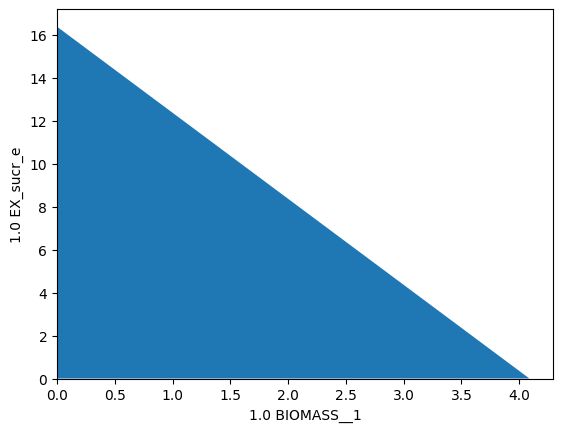

In [6]:
datapoints, triang, plot1 = sd.plot_flux_space(
    model,
    ('BIOMASS__1','EX_sucr_e'),
    show=False
);

In [7]:
def view_with_changes(changed_model):
    datapoints, triang, plot1 = sd.plot_flux_space(
        model,
        ('BIOMASS__1', 'EX_sucr_e'),
        show=False
    );

    plot1.set_facecolor('green')
    plot1.set_edgecolor('green')

    _, _,plot2 = sd.plot_flux_space(
        changed_model,
        ('BIOMASS__1', 'EX_sucr_e'),
        show=False
    );
    plot2.set_facecolor('red')
    plot2.set_edgecolor('red')
    # adjust axes limits and show plot
    plot2.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
    plot2.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
    plt.show()

In [8]:
module_suppress = sd.SDModule(
    consistent_model,
    sd.names.SUPPRESS,
    constraints='EX_sucr_e >= 6.0'
)

module_protect  = sd.SDModule(
    consistent_model,
    sd.names.PROTECT,
    constraints='BIOMASS__1>=.2'
)

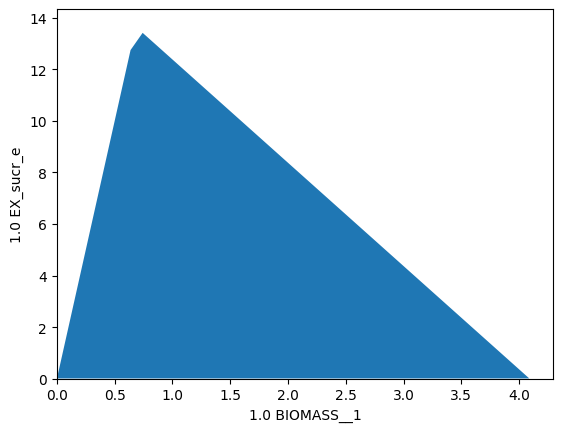

In [9]:
_,          _,      plot3 = sd.plot_flux_space(consistent_model,
                                               ('BIOMASS__1','EX_sucr_e'),
                                               # The sign of the glucose exchange reaction is flipped since
                                               # reaction is defined in the direction of secretion.
                                               constraints=['EX_sucr_e - 20 BIOMASS__1 <= 0',
                                                            'BIOMASS__1 >= 0.01'],
                                               show=False);

In [12]:
rxn_cost = {}
for rxn in consistent_model.reactions:
    if rxn.id.startswith('EX_') or rxn.id.startswith('BIOMASS_') or\
            rxn.id.startswith('SK_') or rxn.id.startswith('PHOA') or\
            rxn.id.startswith('DM_') or rxn.id.startswith('SK_'):
        continue
    if rxn.gene_reaction_rule == '':
        continue
    else:
        rxn_cost[rxn.id] = 1
rxn_cost.pop('BCT1_syn')

1

In [ ]:
from syn_elong.strain_design_simplified import compute_strain_designs, StrainDesign
# Compute strain designs
with consistent_model as m:
    module_suppress = sd.SDModule(
        m,
        sd.names.SUPPRESS,
        constraints=['EX_sucr_e - 4 BIOMASS__1 <= 0',
                     'BIOMASS__1 >= 0.01']
    )
    module_protect  = sd.SDModule(
        m,
        sd.names.PROTECT,
        constraints='BIOMASS__1>=.1'
    )
        module_tilted_optknock = sd.SDModule(m, sd.names.OPTKNOCK,
                                         inner_objective='BIOMASS__1 ',  # - 0.001 EX_14bdo_e
                                         outer_objective='EX_sucr_e',
                                         constraints=['BIOMASS__1  >= 0.2', 'EX_sucr_e >=3'])
    module_optcouple = sd.SDModule(m, sd.names.OPTCOUPLE,
                                   inner_objective='BIOMASS__1',
                                   prod_id='EX_sucr_e',
                                   min_gcp=0.1)
    sd_helper = StrainDesign(
        m,
        # sd_modules=[module_suppress, module_protect],
        sd_modules=[module_tilted_optknock],
        ko_cost=rxn_cost,
        # gene_kos=True,
    )

    sols = sd_helper.run(max_solutions=10, max_cost=5, time_limit=300, solution_approach=sd.names.ANY)

In [3]:


with consistent_model as m:
    module_suppress = sd.SDModule(
        m,
        sd.names.SUPPRESS,
        constraints=['EX_sucr_e - 4 BIOMASS__1 <= 0',
                     'BIOMASS__1 >= 0.01']
    )
    module_protect  = sd.SDModule(
        m,
        sd.names.PROTECT,
        constraints='BIOMASS__1>=.1'
    )
    sd_helper = compute_strain_designs(
        m,
        sd_modules = [module_suppress, module_protect],
        time_limit = 500,
        max_solutions = 3,
        max_cost = 5,
        # gene_kos=False,
        ko_cost=rxn_cost,
        solution_approach = sd.names.ANY
    )
    sols = sd_helper.step_2(max_solutions=5, max_cost=10, time_limit=60, solution_approach=sd.names.ANY)

NameError: name 'consistent_model' is not defined

In [211]:
sols.sd_cost

[4.0, 4.0, 4.0]

In [212]:

# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example knockout set: {[s for s in sols.reaction_sd[0]]}")

One compressed solution with cost 4.0 found and expanded to 3 solutions in the uncompressed netork.
Example knockout set: ['PCXHtpp', 'BCT1_syn', 'CYTBD4cm', 'NTRARf2']


In [ ]:
solutions = sols.reaction_sd

In [213]:
rxns = [
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'NTRIRfx': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'NTRARf2': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'NO3abcpp': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'GND': -1.0, 'PSP_L': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'GND': -1.0, 'PGCD': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'GND': -1.0, 'PSERT': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'PGL': -1.0, 'PSP_L': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'PGL': -1.0, 'PGCD': -1.0},
    {'CYTBD4cm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'PGL': -1.0, 'PSERT': -1.0},
    {'NDHPQRcm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'MNHNAtpp': -1.0, 'NTRIRfx': -1.0},
    {'NDHPQRcm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'MNHNAtpp': -1.0, 'NTRARf2': -1.0},
    {'NDHPQRcm': -1.0, 'BCT1_syn': -1.0, 'PCXHtpp': -1.0, 'MNHNAtpp': -1.0, 'NO3abcpp': -1.0},
]

['CYTBD4cm', 'BCT1_syn', 'PCXHtpp', 'GND', 'PSERT']
CYTBD4cm: 4.0 h_c + o2_c + 2.0 pqh2_cm --> 2.0 h2o_c + 4.0 h_p + 2.0 pq_cm
BCT1_syn: atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c
PCXHtpp: h_c --> h_p
GND: 6pgc_c + nadp_c --> co2_c + nadph_c + ru5p__D_c
PSERT: 3php_c + glu__L_c <=> akg_c + pser__L_c
1.0839043697160782


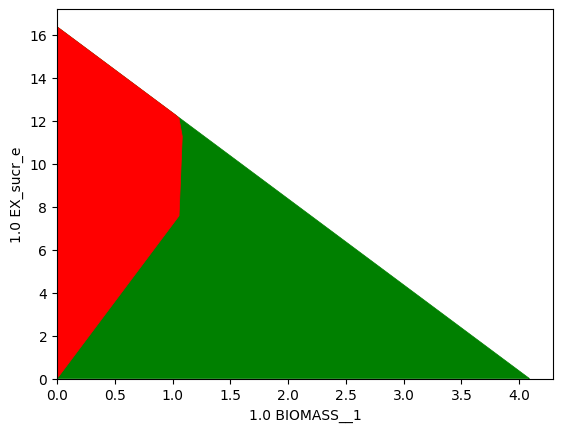

EX_photon690_e   -1000.000
EX_photon670_e    -848.725
H2Otu_syn         -400.367
Htcx              -204.108
O2tex             -192.874
                    ...   
ETCPC              848.725
PHOA670um          848.725
PHOA690um         1000.000
PSICSum           1000.000
PSIum             1000.000
Name: fluxes, Length: 428, dtype: float64

In [77]:
def run_with_intervention(intervention):
    with consistent_model as m:
        print([i for i in intervention])
        for i in intervention:
            print(m.reactions.get_by_id(i))
            # if i == 'BCT1_syn':
            #     continue
            # print(i)
            m.reactions.get_by_id(i).lower_bound = 0
            m.reactions.get_by_id(i).upper_bound = 0
#             m.remove_reactions([m.reactions.get_by_id(i)])
        print(m.slim_optimize())
        sol = m.optimize()

        view_with_changes(m)
        return sol.fluxes #sol.reduced_costs, 
red_costs = run_with_intervention(rxns[5])
red_costs[np.abs(red_costs)>0.001].sort_values()

In [ ]:
red_costs = run_with_intervention(rxns[3])
red_costs[np.abs(red_costs)>0.001].sort_values()

In [ ]:
fl = cobra.flux_analysis.flux_variability_analysis(consistent_model)

In [66]:
model.metabolites.co2_c

Metabolite identifier,co2_c
Name,CO2 CO2
Memory address,0x0258e8be21a0
Formula,CO2
Compartment,c
In 54 reaction(s),"OXADC, CO2tpp, CPPPGO2, 3OAS160, PROAKGOX1, ORNDC, 3OAS100, PFOR, AOXSr2, DBTS, GLYCL, 3OAS120, 3OAS60, DAPDC, SEPHCHCS, PPNDH, CPPPGO, ERTHMMOR, THRPDC, ACLSa, 3OAS180, ICDHyr, PPCDC, KAS14,..."


In [93]:
consistent_model.reactions.BCT1_syn

Reaction identifier,BCT1_syn
Name,Bicarbonate transport via ABC system (periplasm)
Memory address,0x0258eb87c730
Stoichiometry,atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c ATP C10H12N5O13P3 + H2O H2O + Bicarbonate --> ADP C10H12N5O10P2 + H+ + Bicarbonate + Phosphate
GPR,SYNPCC7942_RS07605 and SYNPCC7942_RS07610 and SYNPCC7942_RS07615 and SYNPCC7942_RS07620
Lower bound,0.0
Upper bound,1000.0


In [85]:
consistent_model.metabolites.atp_c.summary()

INFO:cobra.summary.metabolite_summary:Generating new parsimonious flux distribution.


Percent,Flux,Reaction,Definition
2.45%,23.44,ACKr,ac_c + atp_c <=> actp_c + adp_c
89.37%,853.8,ATPSum,3.0 adp_c + 13.0 h_u + 3.0 pi_c <=> 3.0 atp_c + 3.0 h2o_c + 10.0 h_c
5.85%,55.88,PPK,atp_c + pi_c <=> adp_c + ppi_c
0.00%,0.007325,PPK2,atp_c + ppi_c <=> adp_c + pppi_c
2.32%,22.18,PYK,adp_c + h_c + pep_c --> atp_c + pyr_c
0.00%,0.0216,URIDK2r,atp_c + dump_c <=> adp_c + dudp_c
Percent,Flux,Reaction,Definition
1.38%,-13.18,ACCOAC,accoa_c + atp_c + hco3_c --> adp_c + h_c + malcoa_c + pi_c
2.52%,-24.04,ACS,ac_c + atp_c + coa_c --> accoa_c + amp_c + ppi_c
0.00%,-2.092E-05,ADCPS2,adcobhex_c + applp_c + atp_c --> adocbip_c + adp_c + h_c + pi_c


In [ ]:
consistent_model.reactions.HCO3E_1_cx 

In [72]:
consistent_model.reactions.HCO3tcx 

Reaction identifier,HCO3tcx
Name,Bicarbonate transport to carboxyzome
Memory address,0x0258eb887ac0
Stoichiometry,hco3_c --> hco3_cx Bicarbonate --> Bicarbonate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [71]:
consistent_model.metabolites.hco3_cx

Metabolite identifier,hco3_cx
Name,Bicarbonate
Memory address,0x0258eb7764a0
Formula,CHO3
Compartment,cx
In 2 reaction(s),"HCO3tcx, HCO3E_1_cx"


In [47]:
consistent_model.metabolites.hco3_p.reactions

frozenset({<Reaction BCT1_syn at 0x258eb87c730>,
           <Reaction H2CO3_NAt_syn at 0x258eb8873d0>,
           <Reaction HCO3tex at 0x258eb87e860>})

In [48]:
consistent_model.reactions.HCO3tex 

Reaction identifier,HCO3tex
Name,Bicarbonate transport via diffusion (extracellular to periplasm)
Memory address,0x0258eb87e860
Stoichiometry,hco3_e <=> hco3_p Bicarbonate <=> Bicarbonate
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [73]:
consistent_model.reactions.BCT1_syn  

Reaction identifier,BCT1_syn
Name,Bicarbonate transport via ABC system (periplasm)
Memory address,0x0258eb87c730
Stoichiometry,atp_c + h2o_c + hco3_p --> adp_c + h_c + hco3_c + pi_c ATP C10H12N5O13P3 + H2O H2O + Bicarbonate --> ADP C10H12N5O10P2 + H+ + Bicarbonate + Phosphate
GPR,SYNPCC7942_RS07605 and SYNPCC7942_RS07610 and SYNPCC7942_RS07615 and SYNPCC7942_RS07620
Lower bound,0.0
Upper bound,1000.0


In [ ]:
red_costs = run_with_intervention(['GND', 'PSP_L', 'BCT1_syn'])

red_costs[np.abs(red_costs)>0.001].sort_values()

In [53]:
"""
['SYNPCC7942_RS07615',
 'SYNPCC7942_RS07605',
 'SYNPCC7942_RS07620',
 'SYNPCC7942_RS07610']
 
"""
[g.id for g in model.reactions.BCT1_syn.genes]

['SYNPCC7942_RS07615',
 'SYNPCC7942_RS07605',
 'SYNPCC7942_RS07620',
 'SYNPCC7942_RS07610']

[]
4.08828027358269


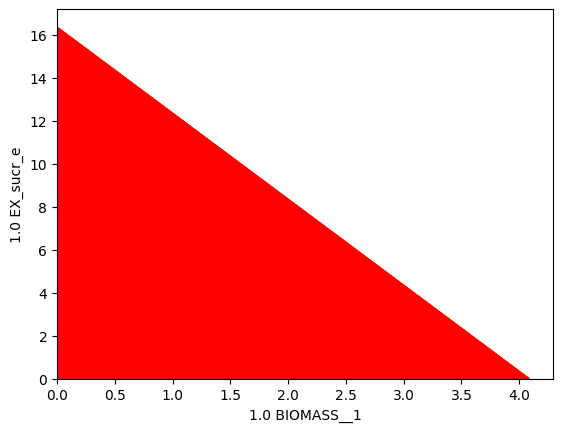

EX_photon690_e   -1000.000
EX_photon670_e   -1000.000
H2Otu_syn         -500.000
O2tex             -194.132
O2tpp             -194.132
                    ...   
ETCPC             1000.000
PSIICSum          1000.000
PHOA670um         1000.000
PSIum             1000.000
PHOA690um         1000.000
Name: fluxes, Length: 446, dtype: float64

In [82]:
red_costs = run_with_intervention(['BCT1_syn'])
red_costs[np.abs(red_costs)>0.001].sort_values()

In [83]:
red_costs[np.abs(red_costs)>0.001].loc['HCO3E_1_cx']

183.52300375243226

['PSP_L']
PSP_L: h2o_c + pser__L_c --> pi_c + ser__L_c
1.9945150376163114


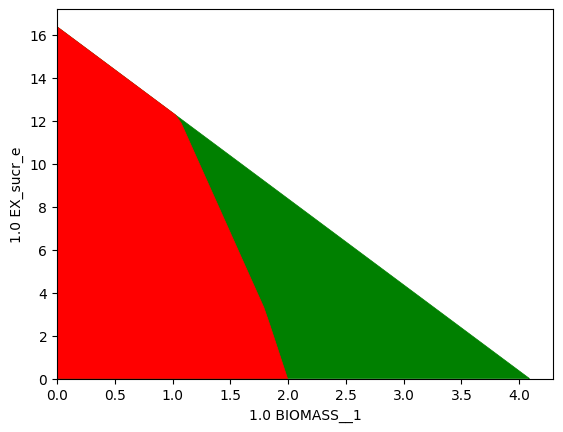

FDH6          -1.527
GLYCK         -1.527
EX_meoh_e     -0.774
SK_for_c      -0.763
EX_sucr_e     -0.122
SK_akg_c      -0.031
PSIICRum      -0.029
DM_succ_c     -0.029
DM_lac__D_c   -0.026
SK_fum_c      -0.026
NTRIRfx       -0.023
ZCAROTDH2     -0.013
DM_ac_c       -0.013
AGDC          -0.013
CYTBD4cm      -0.010
MEHLER_1      -0.010
CMPA_1        -0.010
OXADC         -0.008
NADDP         -0.008
NGAM          -0.007
GTHPi         -0.005
GLYCOX2       -0.005
DM_h2_c       -0.005
LALGP         -0.005
GLUCYS        -0.005
HEX7          -0.005
DCTPD         -0.005
ASNN          -0.005
DCTPD2        -0.005
PKETF         -0.005
PKETX         -0.005
PSP_L          1.524
Name: reduced_costs, dtype: float64

In [43]:
red_costs = run_with_intervention(['PSP_L'])
red_costs[np.abs(red_costs)>0.005].sort_values()

['CYTBD4cm', 'BCT1_syn', 'PCXHtpp', 'GND', 'PSP_L']
1.083904369716062


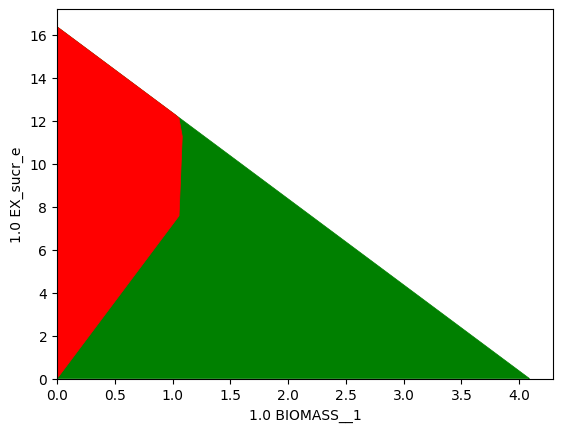

GLYCK              -2.076
FDH6               -2.063
EX_meoh_e          -1.039
SK_for_c           -1.037
DM_succ_c          -0.013
SK_fum_c           -0.013
DM_lac__D_c        -0.007
MEHLER_1           -0.007
PKETF              -0.007
PKETX              -0.007
Kabcpp             -0.006
Htabcpp            -0.006
CMPA_1             -0.004
OXADC              -0.004
GTHPi              -0.004
DM_h2_c            -0.004
GLYCOX2            -0.004
PEPC               -0.004
NDHPQRum           -0.004
ASPOb              -0.004
EX_hco3_e          -0.004
NDH_1_1_um_copy1   -0.004
AGDC               -0.003
NO3abcpp           -0.003
PSICRum            -0.002
PSICSum             0.002
BCT1_syn            0.006
PCXHtpp             0.006
GND                 0.007
CYTBD4cm            0.016
PSP_L               2.076
Name: reduced_costs, dtype: float64

In [29]:
red_costs = run_with_intervention(rxns[3])
red_costs[np.abs(red_costs)>0.001].sort_values()

Htex
EX_hco3_e
NO3abcpp
0.7434414202750895


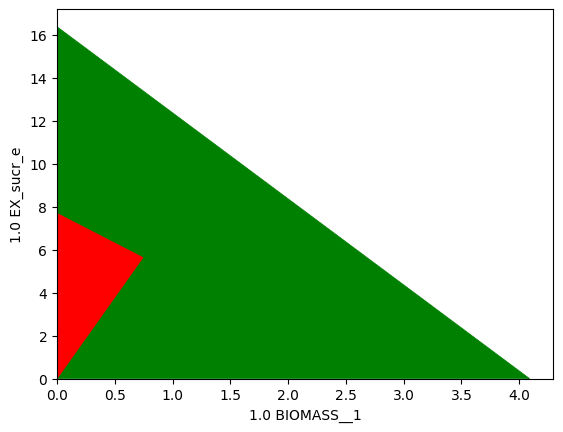

In [78]:
run_with_intervention(sols.reaction_sd[4])

## Optcouple

In [127]:
module_optcouple = sd.SDModule(
    consistent_model,
    sd.names.OPTCOUPLE,
    inner_objective='BIOMASS__1',
    prod_id='EX_sucr_e',
    min_gcp=0.5
)